In [1]:
import pickle
import numpy as np
import neat
import datetime
import os
import math

from comunication_channel import AgentLogChannel

from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.base_env import ActionTuple
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel

In [2]:
NUM_RUNS = 1
MAX_GENS = 3000

generation = 0
SAVE_INTERVAL = 50

In [3]:
engine_config_channel = EngineConfigurationChannel()
engine_config_channel.set_configuration_parameters(time_scale=10)
agent_count_channel = AgentLogChannel()

env_path = "../Builds/train-env/autonomous-drone.exe"
save_nn_destination = '../result/best.pkl'

env = UnityEnvironment(file_name=None, worker_id=0, no_graphics=False, side_channels=[engine_config_channel, agent_count_channel])
env.reset()

In [4]:

behavior_specs = env.behavior_specs
print(f"Behaviour specs {behavior_specs}")
behavior_name = list(behavior_specs)[0]
spec = env.behavior_specs[behavior_name]

print(f"Name of the behavior : {behavior_name}")
print("Number of observations : ", len(spec.observation_specs)) # vector if 1

# Is the Action continuous or multi-discrete ?
if spec.action_spec.continuous_size > 0:
  print(f"There are {spec.action_spec.continuous_size} continuous actions")
if spec.action_spec.is_discrete():
  print(f"There are {spec.action_spec.discrete_size} discrete actions")

Behaviour specs <mlagents_envs.base_env.BehaviorMapping object at 0x000001CF12479750>
Name of the behavior : DroneControl?team=0
Number of observations :  1
There are 4 continuous actions


In [5]:
def create_folder(file_name_prefix):
    directory = os.path.dirname(f"{file_name_prefix}")
    if not os.path.exists(directory):
        os.makedirs(directory)

In [6]:
def set_agents_and_double_reset(num_agents: int):
    agent_count_channel.send_int(data=num_agents) 
    env.reset()
    env.reset()

In [7]:
def get_observation_for_agent(agent: int, observations):
    for observation in observations:
        key = int(observation.split("=")[2])
        if key == agent:
            return observations[observation]

In [8]:
def map_agent_ids(decision_steps):
    """
    Map agent ids between NEAT and UNITY.

    Args:
        decision_steps: An iterable containing decision steps.

    Returns:
        A tuple of two dictionaries: (unity_to_neat_map, neat_to_unity_map)
    """
    unity_to_neat_map = {}
    neat_to_unity_map = {}
    id_count = 0
    for step in decision_steps:
        unity_to_neat_map[step] = id_count
        neat_to_unity_map[id_count] = step
        id_count += 1
    return unity_to_neat_map, neat_to_unity_map

In [9]:
def create_policies(genomes, cfg):
    policies = []
    for _, g in genomes:
        g.fitness = 0
        policy = neat.nn.RecurrentNetwork.create(g, cfg)
        policies.append(policy)
    return policies

In [10]:
def eval_genomes(genomes, cfg):
    global generation 
    generation += 1

    policies = create_policies(genomes, cfg)
    set_agents_and_double_reset(len(policies))
    decision_steps, terminal_steps = env.get_steps(behavior_name)
    agent_count = len(decision_steps.agent_id)

    unity_to_neat_map, neat_to_unity_map = map_agent_ids(decision_steps)

    done = False  # Vectorized initialization
    removed_agents = []

    episode_rewards = [0] * agent_count
    print(f"Agent count: {agent_count}")

    while not done:
        for agent in decision_steps:
            if unity_to_neat_map[agent] not in removed_agents:
                nn_input =  np.asarray(decision_steps[agent].obs[:])
                #print(f"NN INPUT: {nn_input}, agent: {agent}")
                #print(f"NN INPUT[0]: {nn_input[0]}, agent: {agent}")
                actions = policies[unity_to_neat_map[agent]].activate(nn_input[0])
                #print(f"NN OUTPUT: {actions}, agent: {agent}")
                continous_actions = np.asarray([actions])
                # continous_actions = np.clip(continous_actions, -1, 1)
                action_tuple = ActionTuple(discrete=None, continuous=continous_actions)
                env.set_action_for_agent(behavior_name=behavior_name, 
                                        agent_id=agent, 
                                        action=action_tuple)
        env.step()
        decision_steps, terminal_steps = env.get_steps(behavior_name)
        for agent in range(agent_count):
            if agent not in removed_agents:
                local_agent = neat_to_unity_map[agent]
                if local_agent in terminal_steps:
                    episode_rewards[agent] += terminal_steps[local_agent].reward
                    removed_agents.append(agent)
                    #print(f"Finished: {agent}")
                elif local_agent in decision_steps:
                    episode_rewards[agent] += decision_steps[local_agent].reward
                 

        if len(removed_agents) >= agent_count:
            done = True
    for i, (_, genome) in enumerate(genomes):
        genome.fitness = episode_rewards[i]
    if generation % SAVE_INTERVAL == 0:
      global file_name_prefix
      best_genome_current_generation = max(genomes, key=lambda x: x[1].fitness) 
      with open(file_name_prefix+'best-'+str(generation)+'.pkl', 'wb') as f:
          pickle.dump(best_genome_current_generation, f)
      

In [11]:
def run(config_file, run, datte):
    print(f"Running {run}")
    global file_name_prefix
    file_name_prefix = f"../checkpoints/{datte}/run-{run}/"
    create_folder(file_name_prefix=file_name_prefix)

    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    
    pop = neat.Population(config)

    stats = neat.StatisticsReporter()

    pop.add_reporter(stats)
    pop.add_reporter(neat.TBReporter(True, 0, run, datte))
    #pop.add_reporter(neat.StdOutReporter(True))
    best = pop.run(eval_genomes, MAX_GENS)
    # Display the winning genome.
    # print('\nBest genome:\n{!s}'.format(best))
    print("Finished running!")
    
    # Save best genome
    with open(f'logs/{datte}/{run}/best.pkl', 'wb') as f:
        pickle.dump(best, f)

In [12]:
config_path = '../configs/config-recurrent'
datte = datetime.datetime.now().strftime("%d-%m-%Y--%H_%M")
# pre create folders for checkpointer
for r in range(NUM_RUNS):
    run(config_path, r, datte)                      

Running 0

 ****** Running generation 0 ****** 

Agent count: 50
Population's average fitness: -1.00000 stdev: 0.00000
Best fitness: -0.99998 - size: (4, 34) - species 1 - id 4
Best fitness ever found! : -0.9999842963971624
Population of 50 members in 1 species:
   ID   age  size   fitness   adj fit  stag
  ====  ===  ====  =========  =======  ====
     1    0    50  -0.9999842963971624  4.689661358137087e-07     0
Total extinctions: 0
Generation time: 3.309 sec

 ****** Running generation 1 ****** 

Agent count: 50
Population's average fitness: -0.99999 stdev: 0.00004
Best fitness: -0.99975 - size: (5, 35) - species 1 - id 66
Best fitness ever found! : -0.9997490906074802
Population of 50 members in 1 species:
   ID   age  size   fitness   adj fit  stag
  ====  ===  ====  =========  =======  ====
     1    1    50  -0.9997490906074802  7.799971779576254e-06     0
Total extinctions: 0
Generation time: 2.788 sec (3.048 average)

 ****** Running generation 2 ****** 

Agent count: 50
Popu

UnityCommunicatorStoppedException: Communicator has exited.

In [ ]:
env.close()


Best genome:
Key: 142841
Fitness: 226.4790154992146
Nodes:
	0 DefaultNodeGene(key=0, bias=0.0, response=1.0, activation=clamped, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=0.0, response=1.0, activation=clamped, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=0.0, response=1.0, activation=clamped, aggregation=sum)
	3 DefaultNodeGene(key=3, bias=0.0, response=1.0, activation=clamped, aggregation=sum)
	18587 DefaultNodeGene(key=18587, bias=0.0, response=1.0, activation=clamped, aggregation=sum)
	19266 DefaultNodeGene(key=19266, bias=0.0, response=1.0, activation=clamped, aggregation=sum)
	23443 DefaultNodeGene(key=23443, bias=0.0, response=1.0, activation=clamped, aggregation=sum)
	33233 DefaultNodeGene(key=33233, bias=0.0, response=1.0, activation=clamped, aggregation=sum)
	57885 DefaultNodeGene(key=57885, bias=0.0, response=1.0, activation=clamped, aggregation=sum)
	61124 DefaultNodeGene(key=61124, bias=0.0, response=1.0, activation=clamped, aggregation=sum)
Connections:
	DefaultC

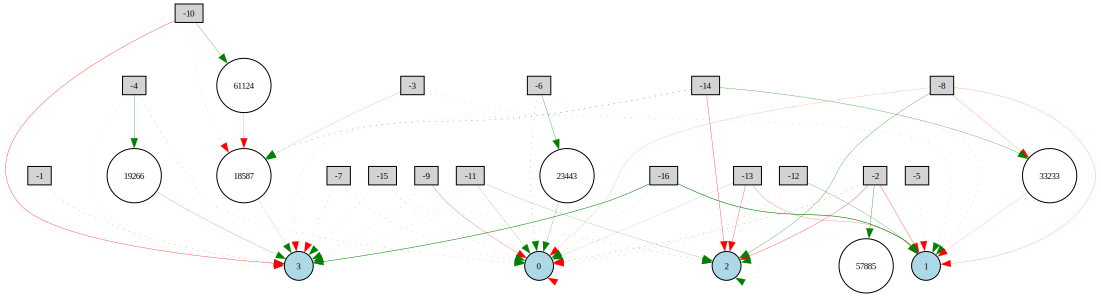

In [ ]:
import visualize
import pickle
import neat
save_nn_destination = '../result/best-recurrent/0/best.pkl'
config_path = '../configs/config-recurrent'

with open(save_nn_destination, "rb") as f:
    genome = pickle.load(f)
    #genome = genome[1]
    print('\nBest genome:\n{!s}'.format(genome))
print(genome.fitness)
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                    neat.DefaultSpeciesSet, neat.DefaultStagnation,
                    config_path)
visualize.draw_net(config, genome, True)